# Projeto 1 - KNN

**Tópicos Especiais em Inteligência Artificial: Machine Learning**

**Dimitri Leandro de Oliveira Silva**

**11201720576**

Para esse projeto, foi necessário implementar o classificador KNN. Na célula abaixo, importarei a classe elaborada para prosseguir com a obtenção de resultados.

In [1]:
import sys
sys.path.append("/home/dimi/Programming/MachineLearningUFABC/Projeto_KNN/python/")

from KNNClass import KNN
from MetricasClass import Metricas

Outras importações e ajustes para plotar gráficos mais bonitos.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.datasets import fetch_olivetti_faces
from time import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix

In [21]:
#DEFININDO ALGUNS PARÂMETROS PARA PLOTAR GRÁFICOS
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
params = {'figure.figsize': [10, 5], 
          'axes.labelsize': 10,
          'axes.titlesize':14, 
          'font.size': 10,
          'legend.fontsize': 10, 
          'xtick.labelsize': 8, 
          'ytick.labelsize': 8
         }
plt.rcParams.update(params)

In [4]:
def salvarResultados(destino, arrayMatrizConfusaoDimi, arrayMatrizConfusaoSKLearn, arrayTemposDimi, arrayTemposSKLearn):
    
    # SE O ARQUIVO JA EXISTIR ELE MORRE
    if os.path.exists(destino):
        os.remove(destino)
        print("O arquivo já existia no destino. Ele foi substituído pela nova versão.")
    
    # SALVANDO OS ARRAYS COMO STRINGS
    texto =  str(arrayMatrizConfusaoDimi).replace("\n", "").replace(" ", "") + "\n"
    texto += str(arrayMatrizConfusaoSKLearn).replace("\n", "").replace(" ", "") + "\n"
    texto += str(arrayTemposDimi).replace("\n", "").replace(" ", "") + "\n"
    texto += str(arrayTemposSKLearn).replace("\n", "").replace(" ", "")
    
    # ESCREVENDO
    f = open(destino, "w")
    f.write(texto)
    f.close()

## Parte 1

Importando os datasets 1 até 6 e os plotando para melhor visualização.

In [ ]:
colunas  = ["feature1", "feature2", "classe"]

dataset1 = pd.read_csv('/home/dimi/Programming/MachineLearningUFABC/Projeto_KNN/datasets/Parte_1/dataset1.txt', names=colunas, header=None)
dataset2 = pd.read_csv('/home/dimi/Programming/MachineLearningUFABC/Projeto_KNN/datasets/Parte_1/dataset2.txt', names=colunas, header=None)
dataset3 = pd.read_csv('/home/dimi/Programming/MachineLearningUFABC/Projeto_KNN/datasets/Parte_1/dataset3.txt', names=colunas, header=None)
dataset4 = pd.read_csv('/home/dimi/Programming/MachineLearningUFABC/Projeto_KNN/datasets/Parte_1/dataset4.txt', names=colunas, header=None)
dataset5 = pd.read_csv('/home/dimi/Programming/MachineLearningUFABC/Projeto_KNN/datasets/Parte_1/dataset5.txt', names=colunas, header=None)
dataset6 = pd.read_csv('/home/dimi/Programming/MachineLearningUFABC/Projeto_KNN/datasets/Parte_1/dataset6.txt', names=colunas, header=None)

In [ ]:
fig, axes = plt.subplots(2, 3)

axes[0, 0].scatter(dataset1["feature1"], dataset1["feature2"], c=dataset1["classe"])
axes[0, 0].set_title("Dataset 1")
axes[0, 0].set_xlabel("Feature 1")
axes[0, 0].set_ylabel("Feature 2")
axes[0, 0].grid(True, alpha=0.25)

axes[0, 1].scatter(dataset2["feature1"], dataset2["feature2"], c=dataset2["classe"])
axes[0, 1].set_title("Dataset 2")
axes[0, 1].set_xlabel("Feature 1")
axes[0, 1].set_ylabel("Feature 2")
axes[0, 1].grid(True, alpha=0.25)

axes[0, 2].scatter(dataset3["feature1"], dataset3["feature2"], c=dataset3["classe"])
axes[0, 2].set_title("Dataset 3")
axes[0, 2].set_xlabel("Feature 1")
axes[0, 2].set_ylabel("Feature 2")
axes[0, 2].grid(True, alpha=0.25)

axes[1, 0].scatter(dataset4["feature1"], dataset4["feature2"], c=dataset4["classe"])
axes[1, 0].set_title("Dataset 4")
axes[1, 0].set_xlabel("Feature 1")
axes[1, 0].set_ylabel("Feature 2")
axes[1, 0].grid(True, alpha=0.25)

axes[1, 1].scatter(dataset5["feature1"], dataset5["feature2"], c=dataset5["classe"])
axes[1, 1].set_title("Dataset 5")
axes[1, 1].set_xlabel("Feature 1")
axes[1, 1].set_ylabel("Feature 2")
axes[1, 1].grid(True, alpha=0.25)

axes[1, 2].scatter(dataset6["feature1"], dataset6["feature2"], c=dataset6["classe"])
axes[1, 2].set_title("Dataset 6")
axes[1, 2].set_xlabel("Feature 1")
axes[1, 2].set_ylabel("Feature 2")
axes[1, 2].grid(True, alpha=0.25)

fig.tight_layout(pad=2)

#plt.savefig("../resultados/datasetsParte1.pfd", format='pdf', bbox_inches = 'tight')

plt.show()

### Parâmetros Iniciais

In [ ]:
arrayValoresK = np.arange(1, 10, 2)
qtdHoldouts   = 5

### Dataset 1

In [ ]:
%%time

# PEGO OS DADOS DO DATASET COMO ARRAYS E NAO PANDAS
x = dataset1[["feature1", "feature2"]].values
y = dataset1["classe"].values

# ARRAYS COM OS RESULTADOS
arrayMatrizConfusaoDimi    = [] # cada linha um valor de k cada coluna um holdout
arrayMatrizConfusaoSKLearn = [] # cada linha um valor de k cada coluna um holdout
arrayTemposDimi            = [] # cada linha um valor de k cada coluna um holdout
arrayTemposSKLearn         = [] # cada linha um valor de k cada coluna um holdout

# PARA CADA VALOR DE K
for kAtual in arrayValoresK:
    
    linhaKAtualMatrizConfusaoDimi    = []
    linhaKAtualMatrizConfusaoSKLearn = []
    linhaKAtualTemposDimi            = []
    linhaKAtualTemposSklearn         = []
    
    # FACO UM BOOTSTRAP COM qtdHoldouts HOLDOUTS
    for crossValidation in range(qtdHoldouts):
        
        # SEPARANDO ENTRE DADOS DE TREINAMENTO E TESTE
        xTrain, xTest, yTrain, yTest = tts(x, y, test_size=0.25, shuffle=True)
        
        # UTILIZANDO A CLASSE CRIADA PARA O KNN
        inicioDimi = time()
        objKNNDimi = KNN(kAtual)
        objKNNDimi.treinar(xTrain, yTrain)
        yPredDimi  = objKNNDimi.predizer(xTest)
        fimDimi = time()
        
        # UTILIZANDO O SKLEARN
        inicioSKLearn = time()
        objKNNSKLearn = KNeighborsClassifier(n_neighbors=kAtual).fit(xTrain, yTrain)
        yPredSKLearn  = objKNNSKLearn.predict(xTest)
        fimSKLearn    = time()
        
        # COLOCANDO O RESULTADO NA LINHA DO K ATUAL NOS ARRAYS DE RESULTADOS
        linhaKAtualMatrizConfusaoDimi.append(confusion_matrix(yTest, yPredDimi))
        linhaKAtualMatrizConfusaoSKLearn.append(confusion_matrix(yTest, yPredSKLearn))
        linhaKAtualTemposDimi.append(fimDimi - inicioDimi)
        linhaKAtualTemposSklearn.append(fimSKLearn - inicioSKLearn)
        
    # AGORA QUE JA TENHO TODOS OS RESULTADOS DO HOLDOUT PARA O K ATUAL, COLOCO A NOVA LINHA NA MATRIZ
    arrayMatrizConfusaoDimi.append(linhaKAtualMatrizConfusaoDimi)
    arrayMatrizConfusaoSKLearn.append(linhaKAtualMatrizConfusaoSKLearn)
    arrayTemposDimi.append(linhaKAtualTemposDimi)
    arrayTemposSKLearn.append(linhaKAtualTemposSklearn)
    
# SALVANDO OS RESULTADOS
salvarResultados("../resultados/dumps/dataset1.txt", arrayMatrizConfusaoDimi, arrayMatrizConfusaoSKLearn, arrayTemposDimi, arrayTemposSKLearn)

### Dataset 2

In [ ]:
%%time

# PEGO OS DADOS DO DATASET COMO ARRAYS E NAO PANDAS
x = dataset2[["feature1", "feature2"]].values
y = dataset2["classe"].values

# ARRAYS COM OS RESULTADOS
arrayMatrizConfusaoDimi    = [] # cada linha um valor de k cada coluna um holdout
arrayMatrizConfusaoSKLearn = [] # cada linha um valor de k cada coluna um holdout
arrayTemposDimi            = [] # cada linha um valor de k cada coluna um holdout
arrayTemposSKLearn         = [] # cada linha um valor de k cada coluna um holdout

# PARA CADA VALOR DE K
for kAtual in arrayValoresK:
    
    linhaKAtualMatrizConfusaoDimi    = []
    linhaKAtualMatrizConfusaoSKLearn = []
    linhaKAtualTemposDimi            = []
    linhaKAtualTemposSklearn         = []
    
    # FACO UM BOOTSTRAP COM qtdHoldouts HOLDOUTS
    for crossValidation in range(qtdHoldouts):
        
        # SEPARANDO ENTRE DADOS DE TREINAMENTO E TESTE
        xTrain, xTest, yTrain, yTest = tts(x, y, test_size=0.25, shuffle=True)
        
        # UTILIZANDO A CLASSE CRIADA PARA O KNN
        inicioDimi = time()
        objKNNDimi = KNN(kAtual)
        objKNNDimi.treinar(xTrain, yTrain)
        yPredDimi  = objKNNDimi.predizer(xTest)
        fimDimi = time()
        
        # UTILIZANDO O SKLEARN
        inicioSKLearn = time()
        objKNNSKLearn = KNeighborsClassifier(n_neighbors=kAtual).fit(xTrain, yTrain)
        yPredSKLearn  = objKNNSKLearn.predict(xTest)
        fimSKLearn    = time()
        
        # COLOCANDO O RESULTADO NA LINHA DO K ATUAL NOS ARRAYS DE RESULTADOS
        linhaKAtualMatrizConfusaoDimi.append(confusion_matrix(yTest, yPredDimi))
        linhaKAtualMatrizConfusaoSKLearn.append(confusion_matrix(yTest, yPredSKLearn))
        linhaKAtualTemposDimi.append(fimDimi - inicioDimi)
        linhaKAtualTemposSklearn.append(fimSKLearn - inicioSKLearn)
        
    # AGORA QUE JA TENHO TODOS OS RESULTADOS DO HOLDOUT PARA O K ATUAL, COLOCO A NOVA LINHA NA MATRIZ
    arrayMatrizConfusaoDimi.append(linhaKAtualMatrizConfusaoDimi)
    arrayMatrizConfusaoSKLearn.append(linhaKAtualMatrizConfusaoSKLearn)
    arrayTemposDimi.append(linhaKAtualTemposDimi)
    arrayTemposSKLearn.append(linhaKAtualTemposSklearn)
    
# SALVANDO OS RESULTADOS
salvarResultados("../resultados/dumps/dataset2.txt", arrayMatrizConfusaoDimi, arrayMatrizConfusaoSKLearn, arrayTemposDimi, arrayTemposSKLearn)

### Dataset 3

In [ ]:
%%time

# PEGO OS DADOS DO DATASET COMO ARRAYS E NAO PANDAS
x = dataset3[["feature1", "feature2"]].values
y = dataset3["classe"].values

# ARRAYS COM OS RESULTADOS
arrayMatrizConfusaoDimi    = [] # cada linha um valor de k cada coluna um holdout
arrayMatrizConfusaoSKLearn = [] # cada linha um valor de k cada coluna um holdout
arrayTemposDimi            = [] # cada linha um valor de k cada coluna um holdout
arrayTemposSKLearn         = [] # cada linha um valor de k cada coluna um holdout

# PARA CADA VALOR DE K
for kAtual in arrayValoresK:
    
    linhaKAtualMatrizConfusaoDimi    = []
    linhaKAtualMatrizConfusaoSKLearn = []
    linhaKAtualTemposDimi            = []
    linhaKAtualTemposSklearn         = []
    
    # FACO UM BOOTSTRAP COM qtdHoldouts HOLDOUTS
    for crossValidation in range(qtdHoldouts):
        
        # SEPARANDO ENTRE DADOS DE TREINAMENTO E TESTE
        xTrain, xTest, yTrain, yTest = tts(x, y, test_size=0.25, shuffle=True)
        
        # UTILIZANDO A CLASSE CRIADA PARA O KNN
        inicioDimi = time()
        objKNNDimi = KNN(kAtual)
        objKNNDimi.treinar(xTrain, yTrain)
        yPredDimi  = objKNNDimi.predizer(xTest)
        fimDimi = time()
        
        # UTILIZANDO O SKLEARN
        inicioSKLearn = time()
        objKNNSKLearn = KNeighborsClassifier(n_neighbors=kAtual).fit(xTrain, yTrain)
        yPredSKLearn  = objKNNSKLearn.predict(xTest)
        fimSKLearn    = time()
        
        # COLOCANDO O RESULTADO NA LINHA DO K ATUAL NOS ARRAYS DE RESULTADOS
        linhaKAtualMatrizConfusaoDimi.append(confusion_matrix(yTest, yPredDimi))
        linhaKAtualMatrizConfusaoSKLearn.append(confusion_matrix(yTest, yPredSKLearn))
        linhaKAtualTemposDimi.append(fimDimi - inicioDimi)
        linhaKAtualTemposSklearn.append(fimSKLearn - inicioSKLearn)
        
    # AGORA QUE JA TENHO TODOS OS RESULTADOS DO HOLDOUT PARA O K ATUAL, COLOCO A NOVA LINHA NA MATRIZ
    arrayMatrizConfusaoDimi.append(linhaKAtualMatrizConfusaoDimi)
    arrayMatrizConfusaoSKLearn.append(linhaKAtualMatrizConfusaoSKLearn)
    arrayTemposDimi.append(linhaKAtualTemposDimi)
    arrayTemposSKLearn.append(linhaKAtualTemposSklearn)
    
# SALVANDO OS RESULTADOS
salvarResultados("../resultados/dumps/dataset3.txt", arrayMatrizConfusaoDimi, arrayMatrizConfusaoSKLearn, arrayTemposDimi, arrayTemposSKLearn)

### Dataset 4

In [ ]:
%%time

# PEGO OS DADOS DO DATASET COMO ARRAYS E NAO PANDAS
x = dataset4[["feature1", "feature2"]].values
y = dataset4["classe"].values

# ARRAYS COM OS RESULTADOS
arrayMatrizConfusaoDimi    = [] # cada linha um valor de k cada coluna um holdout
arrayMatrizConfusaoSKLearn = [] # cada linha um valor de k cada coluna um holdout
arrayTemposDimi            = [] # cada linha um valor de k cada coluna um holdout
arrayTemposSKLearn         = [] # cada linha um valor de k cada coluna um holdout

# PARA CADA VALOR DE K
for kAtual in arrayValoresK:
    
    linhaKAtualMatrizConfusaoDimi    = []
    linhaKAtualMatrizConfusaoSKLearn = []
    linhaKAtualTemposDimi            = []
    linhaKAtualTemposSklearn         = []
    
    # FACO UM BOOTSTRAP COM qtdHoldouts HOLDOUTS
    for crossValidation in range(qtdHoldouts):
        
        # SEPARANDO ENTRE DADOS DE TREINAMENTO E TESTE
        xTrain, xTest, yTrain, yTest = tts(x, y, test_size=0.25, shuffle=True)
        
        # UTILIZANDO A CLASSE CRIADA PARA O KNN
        inicioDimi = time()
        objKNNDimi = KNN(kAtual)
        objKNNDimi.treinar(xTrain, yTrain)
        yPredDimi  = objKNNDimi.predizer(xTest)
        fimDimi = time()
        
        # UTILIZANDO O SKLEARN
        inicioSKLearn = time()
        objKNNSKLearn = KNeighborsClassifier(n_neighbors=kAtual).fit(xTrain, yTrain)
        yPredSKLearn  = objKNNSKLearn.predict(xTest)
        fimSKLearn    = time()
        
        # COLOCANDO O RESULTADO NA LINHA DO K ATUAL NOS ARRAYS DE RESULTADOS
        linhaKAtualMatrizConfusaoDimi.append(confusion_matrix(yTest, yPredDimi))
        linhaKAtualMatrizConfusaoSKLearn.append(confusion_matrix(yTest, yPredSKLearn))
        linhaKAtualTemposDimi.append(fimDimi - inicioDimi)
        linhaKAtualTemposSklearn.append(fimSKLearn - inicioSKLearn)
        
    # AGORA QUE JA TENHO TODOS OS RESULTADOS DO HOLDOUT PARA O K ATUAL, COLOCO A NOVA LINHA NA MATRIZ
    arrayMatrizConfusaoDimi.append(linhaKAtualMatrizConfusaoDimi)
    arrayMatrizConfusaoSKLearn.append(linhaKAtualMatrizConfusaoSKLearn)
    arrayTemposDimi.append(linhaKAtualTemposDimi)
    arrayTemposSKLearn.append(linhaKAtualTemposSklearn)
    
# SALVANDO OS RESULTADOS
salvarResultados("../resultados/dumps/dataset4.txt", arrayMatrizConfusaoDimi, arrayMatrizConfusaoSKLearn, arrayTemposDimi, arrayTemposSKLearn)

### Dataset 5

In [ ]:
%%time

# PEGO OS DADOS DO DATASET COMO ARRAYS E NAO PANDAS
x = dataset5[["feature1", "feature2"]].values
y = dataset5["classe"].values

# ARRAYS COM OS RESULTADOS
arrayMatrizConfusaoDimi    = [] # cada linha um valor de k cada coluna um holdout
arrayMatrizConfusaoSKLearn = [] # cada linha um valor de k cada coluna um holdout
arrayTemposDimi            = [] # cada linha um valor de k cada coluna um holdout
arrayTemposSKLearn         = [] # cada linha um valor de k cada coluna um holdout

# PARA CADA VALOR DE K
for kAtual in arrayValoresK:
    
    linhaKAtualMatrizConfusaoDimi    = []
    linhaKAtualMatrizConfusaoSKLearn = []
    linhaKAtualTemposDimi            = []
    linhaKAtualTemposSklearn         = []
    
    # FACO UM BOOTSTRAP COM qtdHoldouts HOLDOUTS
    for crossValidation in range(qtdHoldouts):
        
        # SEPARANDO ENTRE DADOS DE TREINAMENTO E TESTE
        xTrain, xTest, yTrain, yTest = tts(x, y, test_size=0.25, shuffle=True)
        
        # UTILIZANDO A CLASSE CRIADA PARA O KNN
        inicioDimi = time()
        objKNNDimi = KNN(kAtual)
        objKNNDimi.treinar(xTrain, yTrain)
        yPredDimi  = objKNNDimi.predizer(xTest)
        fimDimi = time()
        
        # UTILIZANDO O SKLEARN
        inicioSKLearn = time()
        objKNNSKLearn = KNeighborsClassifier(n_neighbors=kAtual).fit(xTrain, yTrain)
        yPredSKLearn  = objKNNSKLearn.predict(xTest)
        fimSKLearn    = time()
        
        # COLOCANDO O RESULTADO NA LINHA DO K ATUAL NOS ARRAYS DE RESULTADOS
        linhaKAtualMatrizConfusaoDimi.append(confusion_matrix(yTest, yPredDimi))
        linhaKAtualMatrizConfusaoSKLearn.append(confusion_matrix(yTest, yPredSKLearn))
        linhaKAtualTemposDimi.append(fimDimi - inicioDimi)
        linhaKAtualTemposSklearn.append(fimSKLearn - inicioSKLearn)
        
    # AGORA QUE JA TENHO TODOS OS RESULTADOS DO HOLDOUT PARA O K ATUAL, COLOCO A NOVA LINHA NA MATRIZ
    arrayMatrizConfusaoDimi.append(linhaKAtualMatrizConfusaoDimi)
    arrayMatrizConfusaoSKLearn.append(linhaKAtualMatrizConfusaoSKLearn)
    arrayTemposDimi.append(linhaKAtualTemposDimi)
    arrayTemposSKLearn.append(linhaKAtualTemposSklearn)
    
# SALVANDO OS RESULTADOS
salvarResultados("../resultados/dumps/dataset5.txt", arrayMatrizConfusaoDimi, arrayMatrizConfusaoSKLearn, arrayTemposDimi, arrayTemposSKLearn)

### Dataset 6

In [ ]:
%%time

# PEGO OS DADOS DO DATASET COMO ARRAYS E NAO PANDAS
x = dataset6[["feature1", "feature2"]].values
y = dataset6["classe"].values

# ARRAYS COM OS RESULTADOS
arrayMatrizConfusaoDimi    = [] # cada linha um valor de k cada coluna um holdout
arrayMatrizConfusaoSKLearn = [] # cada linha um valor de k cada coluna um holdout
arrayTemposDimi            = [] # cada linha um valor de k cada coluna um holdout
arrayTemposSKLearn         = [] # cada linha um valor de k cada coluna um holdout

# PARA CADA VALOR DE K
for kAtual in arrayValoresK:
    
    linhaKAtualMatrizConfusaoDimi    = []
    linhaKAtualMatrizConfusaoSKLearn = []
    linhaKAtualTemposDimi            = []
    linhaKAtualTemposSklearn         = []
    
    # FACO UM BOOTSTRAP COM qtdHoldouts HOLDOUTS
    for crossValidation in range(qtdHoldouts):
        
        # SEPARANDO ENTRE DADOS DE TREINAMENTO E TESTE
        xTrain, xTest, yTrain, yTest = tts(x, y, test_size=0.25, shuffle=True)
        
        # UTILIZANDO A CLASSE CRIADA PARA O KNN
        inicioDimi = time()
        objKNNDimi = KNN(kAtual)
        objKNNDimi.treinar(xTrain, yTrain)
        yPredDimi  = objKNNDimi.predizer(xTest)
        fimDimi = time()
        
        # UTILIZANDO O SKLEARN
        inicioSKLearn = time()
        objKNNSKLearn = KNeighborsClassifier(n_neighbors=kAtual).fit(xTrain, yTrain)
        yPredSKLearn  = objKNNSKLearn.predict(xTest)
        fimSKLearn    = time()
        
        # COLOCANDO O RESULTADO NA LINHA DO K ATUAL NOS ARRAYS DE RESULTADOS
        linhaKAtualMatrizConfusaoDimi.append(confusion_matrix(yTest, yPredDimi))
        linhaKAtualMatrizConfusaoSKLearn.append(confusion_matrix(yTest, yPredSKLearn))
        linhaKAtualTemposDimi.append(fimDimi - inicioDimi)
        linhaKAtualTemposSklearn.append(fimSKLearn - inicioSKLearn)
        
    # AGORA QUE JA TENHO TODOS OS RESULTADOS DO HOLDOUT PARA O K ATUAL, COLOCO A NOVA LINHA NA MATRIZ
    arrayMatrizConfusaoDimi.append(linhaKAtualMatrizConfusaoDimi)
    arrayMatrizConfusaoSKLearn.append(linhaKAtualMatrizConfusaoSKLearn)
    arrayTemposDimi.append(linhaKAtualTemposDimi)
    arrayTemposSKLearn.append(linhaKAtualTemposSklearn)
    
# SALVANDO OS RESULTADOS
salvarResultados("../resultados/dumps/dataset6.txt", arrayMatrizConfusaoDimi, arrayMatrizConfusaoSKLearn, arrayTemposDimi, arrayTemposSKLearn)

## Parte 2

In [ ]:
colunas  = ["feature1", "feature2", "classe"]

dataset1b = pd.read_csv('/home/dimi/Programming/MachineLearningUFABC/Projeto_KNN/datasets/Parte_2/clusterincluster.csv', names=colunas, header=None)
dataset2b = pd.read_csv('/home/dimi/Programming/MachineLearningUFABC/Projeto_KNN/datasets/Parte_2/corners.csv', names=colunas, header=None)
dataset3b = pd.read_csv('/home/dimi/Programming/MachineLearningUFABC/Projeto_KNN/datasets/Parte_2/crescentfullmoon.csv', names=colunas, header=None)
dataset4b = pd.read_csv('/home/dimi/Programming/MachineLearningUFABC/Projeto_KNN/datasets/Parte_2/halfkernel.csv', names=colunas, header=None)
dataset5b = pd.read_csv('/home/dimi/Programming/MachineLearningUFABC/Projeto_KNN/datasets/Parte_2/outlier.csv', names=colunas, header=None)
dataset6b = pd.read_csv('/home/dimi/Programming/MachineLearningUFABC/Projeto_KNN/datasets/Parte_2/twospirals.csv', names=colunas, header=None)

In [ ]:
fig, axes = plt.subplots(2, 3)

axes[0, 0].scatter(dataset1b["feature1"], dataset1b["feature2"], c=dataset1b["classe"])
axes[0, 0].set_title("Cluster in Cluster")
axes[0, 0].set_xlabel("Feature 1")
axes[0, 0].set_ylabel("Feature 2")
axes[0, 0].grid(True, alpha=0.25)

axes[0, 1].scatter(dataset2b["feature1"], dataset2b["feature2"], c=dataset2b["classe"])
axes[0, 1].set_title("Corners")
axes[0, 1].set_xlabel("Feature 1")
axes[0, 1].set_ylabel("Feature 2")
axes[0, 1].grid(True, alpha=0.25)

axes[0, 2].scatter(dataset3b["feature1"], dataset3b["feature2"], c=dataset3b["classe"])
axes[0, 2].set_title("Crescent Full Moon")
axes[0, 2].set_xlabel("Feature 1")
axes[0, 2].set_ylabel("Feature 2")
axes[0, 2].grid(True, alpha=0.25)

axes[1, 0].scatter(dataset4b["feature1"], dataset4b["feature2"], c=dataset4b["classe"])
axes[1, 0].set_title("Half Kernel")
axes[1, 0].set_xlabel("Feature 1")
axes[1, 0].set_ylabel("Feature 2")
axes[1, 0].grid(True, alpha=0.25)

axes[1, 1].scatter(dataset5b["feature1"], dataset5b["feature2"], c=dataset5b["classe"])
axes[1, 1].set_title("Outlier")
axes[1, 1].set_xlabel("Feature 1")
axes[1, 1].set_ylabel("Feature 2")
axes[1, 1].grid(True, alpha=0.25)

axes[1, 2].scatter(dataset6b["feature1"], dataset6b["feature2"], c=dataset6b["classe"])
axes[1, 2].set_title("Two Spirals")
axes[1, 2].set_xlabel("Feature 1")
axes[1, 2].set_ylabel("Feature 2")
axes[1, 2].grid(True, alpha=0.25)

fig.tight_layout(pad=2)

#plt.savefig("../resultados/datasetsParte2.pfd", format='pdf', bbox_inches = 'tight')

plt.show()

### Parâmetros Iniciais

In [ ]:
arrayValoresK = np.arange(1, 20, 2)
qtdHoldouts   = 5

### Cluster in Cluster

In [ ]:
%%time

# PEGO OS DADOS DO DATASET COMO ARRAYS E NAO PANDAS
x = dataset1b[["feature1", "feature2"]].values
y = dataset1b["classe"].values

# ARRAYS COM OS RESULTADOS
arrayMatrizConfusaoDimi    = [] # cada linha um valor de k cada coluna um holdout
arrayMatrizConfusaoSKLearn = [] # cada linha um valor de k cada coluna um holdout
arrayTemposDimi            = [] # cada linha um valor de k cada coluna um holdout
arrayTemposSKLearn         = [] # cada linha um valor de k cada coluna um holdout

# PARA CADA VALOR DE K
for kAtual in arrayValoresK:
    
    linhaKAtualMatrizConfusaoDimi    = []
    linhaKAtualMatrizConfusaoSKLearn = []
    linhaKAtualTemposDimi            = []
    linhaKAtualTemposSklearn         = []
    
    # FACO UM BOOTSTRAP COM qtdHoldouts HOLDOUTS
    for crossValidation in range(qtdHoldouts):
        
        # SEPARANDO ENTRE DADOS DE TREINAMENTO E TESTE
        xTrain, xTest, yTrain, yTest = tts(x, y, test_size=0.25, shuffle=True)
        
        # UTILIZANDO A CLASSE CRIADA PARA O KNN
        inicioDimi = time()
        objKNNDimi = KNN(kAtual)
        objKNNDimi.treinar(xTrain, yTrain)
        yPredDimi  = objKNNDimi.predizer(xTest)
        fimDimi = time()
        
        # UTILIZANDO O SKLEARN
        inicioSKLearn = time()
        objKNNSKLearn = KNeighborsClassifier(n_neighbors=kAtual).fit(xTrain, yTrain)
        yPredSKLearn  = objKNNSKLearn.predict(xTest)
        fimSKLearn    = time()
        
        # COLOCANDO O RESULTADO NA LINHA DO K ATUAL NOS ARRAYS DE RESULTADOS
        linhaKAtualMatrizConfusaoDimi.append(confusion_matrix(yTest, yPredDimi))
        linhaKAtualMatrizConfusaoSKLearn.append(confusion_matrix(yTest, yPredSKLearn))
        linhaKAtualTemposDimi.append(fimDimi - inicioDimi)
        linhaKAtualTemposSklearn.append(fimSKLearn - inicioSKLearn)
        
    # AGORA QUE JA TENHO TODOS OS RESULTADOS DO HOLDOUT PARA O K ATUAL, COLOCO A NOVA LINHA NA MATRIZ
    arrayMatrizConfusaoDimi.append(linhaKAtualMatrizConfusaoDimi)
    arrayMatrizConfusaoSKLearn.append(linhaKAtualMatrizConfusaoSKLearn)
    arrayTemposDimi.append(linhaKAtualTemposDimi)
    arrayTemposSKLearn.append(linhaKAtualTemposSklearn)
    
# SALVANDO OS RESULTADOS
salvarResultados("../resultados/dumps/dataset1b.txt", arrayMatrizConfusaoDimi, arrayMatrizConfusaoSKLearn, arrayTemposDimi, arrayTemposSKLearn)

### Corners

In [ ]:
%%time

# PEGO OS DADOS DO DATASET COMO ARRAYS E NAO PANDAS
x = dataset2b[["feature1", "feature2"]].values
y = dataset2b["classe"].values

# ARRAYS COM OS RESULTADOS
arrayMatrizConfusaoDimi    = [] # cada linha um valor de k cada coluna um holdout
arrayMatrizConfusaoSKLearn = [] # cada linha um valor de k cada coluna um holdout
arrayTemposDimi            = [] # cada linha um valor de k cada coluna um holdout
arrayTemposSKLearn         = [] # cada linha um valor de k cada coluna um holdout

# PARA CADA VALOR DE K
for kAtual in arrayValoresK:
    
    linhaKAtualMatrizConfusaoDimi    = []
    linhaKAtualMatrizConfusaoSKLearn = []
    linhaKAtualTemposDimi            = []
    linhaKAtualTemposSklearn         = []
    
    # FACO UM BOOTSTRAP COM qtdHoldouts HOLDOUTS
    for crossValidation in range(qtdHoldouts):
        
        # SEPARANDO ENTRE DADOS DE TREINAMENTO E TESTE
        xTrain, xTest, yTrain, yTest = tts(x, y, test_size=0.25, shuffle=True)
        
        # UTILIZANDO A CLASSE CRIADA PARA O KNN
        inicioDimi = time()
        objKNNDimi = KNN(kAtual)
        objKNNDimi.treinar(xTrain, yTrain)
        yPredDimi  = objKNNDimi.predizer(xTest)
        fimDimi = time()
        
        # UTILIZANDO O SKLEARN
        inicioSKLearn = time()
        objKNNSKLearn = KNeighborsClassifier(n_neighbors=kAtual).fit(xTrain, yTrain)
        yPredSKLearn  = objKNNSKLearn.predict(xTest)
        fimSKLearn    = time()
        
        # COLOCANDO O RESULTADO NA LINHA DO K ATUAL NOS ARRAYS DE RESULTADOS
        linhaKAtualMatrizConfusaoDimi.append(confusion_matrix(yTest, yPredDimi))
        linhaKAtualMatrizConfusaoSKLearn.append(confusion_matrix(yTest, yPredSKLearn))
        linhaKAtualTemposDimi.append(fimDimi - inicioDimi)
        linhaKAtualTemposSklearn.append(fimSKLearn - inicioSKLearn)
        
    # AGORA QUE JA TENHO TODOS OS RESULTADOS DO HOLDOUT PARA O K ATUAL, COLOCO A NOVA LINHA NA MATRIZ
    arrayMatrizConfusaoDimi.append(linhaKAtualMatrizConfusaoDimi)
    arrayMatrizConfusaoSKLearn.append(linhaKAtualMatrizConfusaoSKLearn)
    arrayTemposDimi.append(linhaKAtualTemposDimi)
    arrayTemposSKLearn.append(linhaKAtualTemposSklearn)
    
# SALVANDO OS RESULTADOS
salvarResultados("../resultados/dumps/dataset2b.txt", arrayMatrizConfusaoDimi, arrayMatrizConfusaoSKLearn, arrayTemposDimi, arrayTemposSKLearn)

### Crescent Full Moon

In [ ]:
%%time

# PEGO OS DADOS DO DATASET COMO ARRAYS E NAO PANDAS
x = dataset3b[["feature1", "feature2"]].values
y = dataset3b["classe"].values

# ARRAYS COM OS RESULTADOS
arrayMatrizConfusaoDimi    = [] # cada linha um valor de k cada coluna um holdout
arrayMatrizConfusaoSKLearn = [] # cada linha um valor de k cada coluna um holdout
arrayTemposDimi            = [] # cada linha um valor de k cada coluna um holdout
arrayTemposSKLearn         = [] # cada linha um valor de k cada coluna um holdout

# PARA CADA VALOR DE K
for kAtual in arrayValoresK:
    
    linhaKAtualMatrizConfusaoDimi    = []
    linhaKAtualMatrizConfusaoSKLearn = []
    linhaKAtualTemposDimi            = []
    linhaKAtualTemposSklearn         = []
    
    # FACO UM BOOTSTRAP COM qtdHoldouts HOLDOUTS
    for crossValidation in range(qtdHoldouts):
        
        # SEPARANDO ENTRE DADOS DE TREINAMENTO E TESTE
        xTrain, xTest, yTrain, yTest = tts(x, y, test_size=0.25, shuffle=True)
        
        # UTILIZANDO A CLASSE CRIADA PARA O KNN
        inicioDimi = time()
        objKNNDimi = KNN(kAtual)
        objKNNDimi.treinar(xTrain, yTrain)
        yPredDimi  = objKNNDimi.predizer(xTest)
        fimDimi = time()
        
        # UTILIZANDO O SKLEARN
        inicioSKLearn = time()
        objKNNSKLearn = KNeighborsClassifier(n_neighbors=kAtual).fit(xTrain, yTrain)
        yPredSKLearn  = objKNNSKLearn.predict(xTest)
        fimSKLearn    = time()
        
        # COLOCANDO O RESULTADO NA LINHA DO K ATUAL NOS ARRAYS DE RESULTADOS
        linhaKAtualMatrizConfusaoDimi.append(confusion_matrix(yTest, yPredDimi))
        linhaKAtualMatrizConfusaoSKLearn.append(confusion_matrix(yTest, yPredSKLearn))
        linhaKAtualTemposDimi.append(fimDimi - inicioDimi)
        linhaKAtualTemposSklearn.append(fimSKLearn - inicioSKLearn)
        
    # AGORA QUE JA TENHO TODOS OS RESULTADOS DO HOLDOUT PARA O K ATUAL, COLOCO A NOVA LINHA NA MATRIZ
    arrayMatrizConfusaoDimi.append(linhaKAtualMatrizConfusaoDimi)
    arrayMatrizConfusaoSKLearn.append(linhaKAtualMatrizConfusaoSKLearn)
    arrayTemposDimi.append(linhaKAtualTemposDimi)
    arrayTemposSKLearn.append(linhaKAtualTemposSklearn)
    
# SALVANDO OS RESULTADOS
salvarResultados("../resultados/dumps/dataset3b.txt", arrayMatrizConfusaoDimi, arrayMatrizConfusaoSKLearn, arrayTemposDimi, arrayTemposSKLearn)

### Half Kernel

In [ ]:
%%time

# PEGO OS DADOS DO DATASET COMO ARRAYS E NAO PANDAS
x = dataset4b[["feature1", "feature2"]].values
y = dataset4b["classe"].values

# ARRAYS COM OS RESULTADOS
arrayMatrizConfusaoDimi    = [] # cada linha um valor de k cada coluna um holdout
arrayMatrizConfusaoSKLearn = [] # cada linha um valor de k cada coluna um holdout
arrayTemposDimi            = [] # cada linha um valor de k cada coluna um holdout
arrayTemposSKLearn         = [] # cada linha um valor de k cada coluna um holdout

# PARA CADA VALOR DE K
for kAtual in arrayValoresK:
    
    linhaKAtualMatrizConfusaoDimi    = []
    linhaKAtualMatrizConfusaoSKLearn = []
    linhaKAtualTemposDimi            = []
    linhaKAtualTemposSklearn         = []
    
    # FACO UM BOOTSTRAP COM qtdHoldouts HOLDOUTS
    for crossValidation in range(qtdHoldouts):
        
        # SEPARANDO ENTRE DADOS DE TREINAMENTO E TESTE
        xTrain, xTest, yTrain, yTest = tts(x, y, test_size=0.25, shuffle=True)
        
        # UTILIZANDO A CLASSE CRIADA PARA O KNN
        inicioDimi = time()
        objKNNDimi = KNN(kAtual)
        objKNNDimi.treinar(xTrain, yTrain)
        yPredDimi  = objKNNDimi.predizer(xTest)
        fimDimi = time()
        
        # UTILIZANDO O SKLEARN
        inicioSKLearn = time()
        objKNNSKLearn = KNeighborsClassifier(n_neighbors=kAtual).fit(xTrain, yTrain)
        yPredSKLearn  = objKNNSKLearn.predict(xTest)
        fimSKLearn    = time()
        
        # COLOCANDO O RESULTADO NA LINHA DO K ATUAL NOS ARRAYS DE RESULTADOS
        linhaKAtualMatrizConfusaoDimi.append(confusion_matrix(yTest, yPredDimi))
        linhaKAtualMatrizConfusaoSKLearn.append(confusion_matrix(yTest, yPredSKLearn))
        linhaKAtualTemposDimi.append(fimDimi - inicioDimi)
        linhaKAtualTemposSklearn.append(fimSKLearn - inicioSKLearn)
        
    # AGORA QUE JA TENHO TODOS OS RESULTADOS DO HOLDOUT PARA O K ATUAL, COLOCO A NOVA LINHA NA MATRIZ
    arrayMatrizConfusaoDimi.append(linhaKAtualMatrizConfusaoDimi)
    arrayMatrizConfusaoSKLearn.append(linhaKAtualMatrizConfusaoSKLearn)
    arrayTemposDimi.append(linhaKAtualTemposDimi)
    arrayTemposSKLearn.append(linhaKAtualTemposSklearn)
    
# SALVANDO OS RESULTADOS
salvarResultados("../resultados/dumps/dataset4b.txt", arrayMatrizConfusaoDimi, arrayMatrizConfusaoSKLearn, arrayTemposDimi, arrayTemposSKLearn)

### Outlier

In [ ]:
%%time

# PEGO OS DADOS DO DATASET COMO ARRAYS E NAO PANDAS
x = dataset5b[["feature1", "feature2"]].values
y = dataset5b["classe"].values

# ARRAYS COM OS RESULTADOS
arrayMatrizConfusaoDimi    = [] # cada linha um valor de k cada coluna um holdout
arrayMatrizConfusaoSKLearn = [] # cada linha um valor de k cada coluna um holdout
arrayTemposDimi            = [] # cada linha um valor de k cada coluna um holdout
arrayTemposSKLearn         = [] # cada linha um valor de k cada coluna um holdout

# PARA CADA VALOR DE K
for kAtual in arrayValoresK:
    
    linhaKAtualMatrizConfusaoDimi    = []
    linhaKAtualMatrizConfusaoSKLearn = []
    linhaKAtualTemposDimi            = []
    linhaKAtualTemposSklearn         = []
    
    # FACO UM BOOTSTRAP COM qtdHoldouts HOLDOUTS
    for crossValidation in range(qtdHoldouts):
        
        # SEPARANDO ENTRE DADOS DE TREINAMENTO E TESTE
        xTrain, xTest, yTrain, yTest = tts(x, y, test_size=0.25, shuffle=True)
        
        # UTILIZANDO A CLASSE CRIADA PARA O KNN
        inicioDimi = time()
        objKNNDimi = KNN(kAtual)
        objKNNDimi.treinar(xTrain, yTrain)
        yPredDimi  = objKNNDimi.predizer(xTest)
        fimDimi = time()
        
        # UTILIZANDO O SKLEARN
        inicioSKLearn = time()
        objKNNSKLearn = KNeighborsClassifier(n_neighbors=kAtual).fit(xTrain, yTrain)
        yPredSKLearn  = objKNNSKLearn.predict(xTest)
        fimSKLearn    = time()
        
        # COLOCANDO O RESULTADO NA LINHA DO K ATUAL NOS ARRAYS DE RESULTADOS
        linhaKAtualMatrizConfusaoDimi.append(confusion_matrix(yTest, yPredDimi))
        linhaKAtualMatrizConfusaoSKLearn.append(confusion_matrix(yTest, yPredSKLearn))
        linhaKAtualTemposDimi.append(fimDimi - inicioDimi)
        linhaKAtualTemposSklearn.append(fimSKLearn - inicioSKLearn)
        
    # AGORA QUE JA TENHO TODOS OS RESULTADOS DO HOLDOUT PARA O K ATUAL, COLOCO A NOVA LINHA NA MATRIZ
    arrayMatrizConfusaoDimi.append(linhaKAtualMatrizConfusaoDimi)
    arrayMatrizConfusaoSKLearn.append(linhaKAtualMatrizConfusaoSKLearn)
    arrayTemposDimi.append(linhaKAtualTemposDimi)
    arrayTemposSKLearn.append(linhaKAtualTemposSklearn)
    
# SALVANDO OS RESULTADOS
salvarResultados("../resultados/dumps/dataset5b.txt", arrayMatrizConfusaoDimi, arrayMatrizConfusaoSKLearn, arrayTemposDimi, arrayTemposSKLearn)

### Two Spirals

In [ ]:
%%time

# PEGO OS DADOS DO DATASET COMO ARRAYS E NAO PANDAS
x = dataset6b[["feature1", "feature2"]].values
y = dataset6b["classe"].values

# ARRAYS COM OS RESULTADOS
arrayMatrizConfusaoDimi    = [] # cada linha um valor de k cada coluna um holdout
arrayMatrizConfusaoSKLearn = [] # cada linha um valor de k cada coluna um holdout
arrayTemposDimi            = [] # cada linha um valor de k cada coluna um holdout
arrayTemposSKLearn         = [] # cada linha um valor de k cada coluna um holdout

# PARA CADA VALOR DE K
for kAtual in arrayValoresK:
    
    linhaKAtualMatrizConfusaoDimi    = []
    linhaKAtualMatrizConfusaoSKLearn = []
    linhaKAtualTemposDimi            = []
    linhaKAtualTemposSklearn         = []
    
    # FACO UM BOOTSTRAP COM qtdHoldouts HOLDOUTS
    for crossValidation in range(qtdHoldouts):
        
        # SEPARANDO ENTRE DADOS DE TREINAMENTO E TESTE
        xTrain, xTest, yTrain, yTest = tts(x, y, test_size=0.25, shuffle=True)
        
        # UTILIZANDO A CLASSE CRIADA PARA O KNN
        inicioDimi = time()
        objKNNDimi = KNN(kAtual)
        objKNNDimi.treinar(xTrain, yTrain)
        yPredDimi  = objKNNDimi.predizer(xTest)
        fimDimi = time()
        
        # UTILIZANDO O SKLEARN
        inicioSKLearn = time()
        objKNNSKLearn = KNeighborsClassifier(n_neighbors=kAtual).fit(xTrain, yTrain)
        yPredSKLearn  = objKNNSKLearn.predict(xTest)
        fimSKLearn    = time()
        
        # COLOCANDO O RESULTADO NA LINHA DO K ATUAL NOS ARRAYS DE RESULTADOS
        linhaKAtualMatrizConfusaoDimi.append(confusion_matrix(yTest, yPredDimi))
        linhaKAtualMatrizConfusaoSKLearn.append(confusion_matrix(yTest, yPredSKLearn))
        linhaKAtualTemposDimi.append(fimDimi - inicioDimi)
        linhaKAtualTemposSklearn.append(fimSKLearn - inicioSKLearn)
        
    # AGORA QUE JA TENHO TODOS OS RESULTADOS DO HOLDOUT PARA O K ATUAL, COLOCO A NOVA LINHA NA MATRIZ
    arrayMatrizConfusaoDimi.append(linhaKAtualMatrizConfusaoDimi)
    arrayMatrizConfusaoSKLearn.append(linhaKAtualMatrizConfusaoSKLearn)
    arrayTemposDimi.append(linhaKAtualTemposDimi)
    arrayTemposSKLearn.append(linhaKAtualTemposSklearn)
    
# SALVANDO OS RESULTADOS
salvarResultados("../resultados/dumps/dataset6b.txt", arrayMatrizConfusaoDimi, arrayMatrizConfusaoSKLearn, arrayTemposDimi, arrayTemposSKLearn)

## Parte 3 - Olivetti Faces

In [5]:
def plotar(nomeDataset, valoresK, mediaAcuracias, mediaPrecisoesMedias, mediaRevocacoesMedias, desvPadAcuracias, desvPadPrecisoesMedias, desvPadRevocacoesMedias, mediaTemposDimi, mediaTemposSK, desvPadTemposDimi, desvPadTemposSK):
    
    fig, ax1 = plt.subplots()

    ax1.errorbar(valoresK, mediaPrecisoesMedias, yerr=desvPadPrecisoesMedias, fmt=".--", linewidth=1, elinewidth=1, capsize=2, label="Precisão Média", color="#9467bd")
    ax1.errorbar(valoresK, mediaRevocacoesMedias, yerr=desvPadRevocacoesMedias, fmt=".--", linewidth=1, elinewidth=1, capsize=2, label="Revocação Média", color="#d62728")
    ax1.errorbar(valoresK, mediaAcuracias, yerr=desvPadAcuracias, fmt=".--", linewidth=1, elinewidth=1, capsize=2, label="Acurácia", color="#1f77b4")
    ax1.set_xlabel("Valor de K")
    ax1.set_ylabel("Métricas")

    ax2 = ax1.twinx()

    ax2.errorbar(valoresK, mediaTemposDimi, yerr=desvPadTemposDimi, fmt=".--", linewidth=1, elinewidth=1, capsize=2, label="Tempo Algoritmo Próprio", color="#ff7f0e")
    ax2.errorbar(valoresK, mediaTemposSK, yerr=desvPadTemposSK, fmt=".--", linewidth=1, elinewidth=1, capsize=2, label="Tempo Scikit Learn", color="#2ca02c")
    ax2.set_ylabel("Tempo de Processamento (s)")
    

    plt.title("Resultados para o " + nomeDataset)
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='upper left')
    plt.xticks(valoresK)
    ax1.grid(alpha=0.25)
    plt.tight_layout()
    
    caminhoSalvarPDF = "../resultados/imagens/resultado_" + nomeDataset.replace(" ", "") + ".pdf"
    plt.savefig(caminhoSalvarPDF, format='pdf', bbox_inches = 'tight')
    plt.show()

In [6]:
def obterResultados(arrayMatrizesConfusaoDimi, arrayTemposDimi, arrayTemposSK):
    
    # RANGE DE K'S
    valoresK = np.arange(1, len(arrayMatrizesConfusaoDimi)*2, 2)

    # CRIANDO OS ARRAYS QUE VAO GUARDAR AS METRICAS PARA CADA VALOR DE K
    mediaAcuracias          = []
    mediaPrecisoesMedias    = []
    mediaRevocacoesMedias   = []
    desvPadAcuracias        = []
    desvPadPrecisoesMedias  = [] 
    desvPadRevocacoesMedias = []
    mediaTempoDimi          = []
    mediaTempoSK            = []
    desvPadTempoDimi        = []
    desvPadTempoSK          = []

    # PARA CADA VALOR DE K
    for iteracaoK, matrizesKAtual in enumerate(arrayMatrizesConfusaoDimi):

        # VOU GUARDAR AS METRICAS DOS HOLDOUTS
        acuraciasKAtual        = []
        precisoesMediasKAtual  = []
        revocacoesMediasKAtual = []

        # E OS TEMPOS JA POSSO PEGAR TUDO DO K ATUAL
        mediaTempoDimi.append(np.mean(arrayTemposDimi[iteracaoK]))
        mediaTempoSK.append(np.mean(arrayTemposSK[iteracaoK]))
        desvPadTempoDimi.append(np.std(arrayTemposDimi[iteracaoK]))
        desvPadTempoSK.append(np.std(arrayTemposSK[iteracaoK]))

        # PARA CADA HOLDOUT
        for matrizConfusaoAtual in matrizesKAtual:        

            # CALCULO TODAS AS METRICAS E COLOCO NOS ARRAYS DO K ATUAL
            objMetricas = Metricas(matrizConfusaoAtual)
            acuraciasKAtual.append(objMetricas.acuracia)
            precisoesMediasKAtual.append(objMetricas.mediaPrecisoes)
            revocacoesMediasKAtual.append(objMetricas.mediaRevocacoes)

        # AGORA QUE JA TENHO OS RESULTADOS DO K ATUAL, VOU PREENCHER UMA NOVA LINHA DOS ARRAYS GERAIS
        mediaAcuracias.append(np.mean(acuraciasKAtual))
        mediaPrecisoesMedias.append(np.mean(precisoesMediasKAtual))
        mediaRevocacoesMedias.append(np.mean(revocacoesMediasKAtual))
        desvPadAcuracias.append(np.std(acuraciasKAtual))
        desvPadPrecisoesMedias.append(np.std(precisoesMediasKAtual))
        desvPadRevocacoesMedias.append(np.std(revocacoesMediasKAtual))
    
    return valoresK, mediaAcuracias, mediaPrecisoesMedias, mediaRevocacoesMedias, desvPadAcuracias, desvPadPrecisoesMedias, desvPadRevocacoesMedias, mediaTempoDimi, mediaTempoSK, desvPadTempoDimi, desvPadTempoSK

In [7]:
datasetOlivetti = fetch_olivetti_faces()
x = datasetOlivetti.data
y = datasetOlivetti.target

In [8]:
print(x.shape)
print(y.shape)

(400, 4096)
(400,)


In [9]:
%%time

# ARRAYS COM OS RESULTADOS
arrayMatrizConfusaoDimi    = [] # cada linha um valor de k cada coluna um holdout
arrayMatrizConfusaoSKLearn = [] # cada linha um valor de k cada coluna um holdout
arrayTemposDimi            = [] # cada linha um valor de k cada coluna um holdout
arrayTemposSKLearn         = [] # cada linha um valor de k cada coluna um holdout

# PARA CADA VALOR DE K
for kAtual in np.arange(1, 20, 2):
    
    print("K Atual:", kAtual)
    
    linhaKAtualMatrizConfusaoDimi    = []
    linhaKAtualMatrizConfusaoSKLearn = []
    linhaKAtualTemposDimi            = []
    linhaKAtualTemposSklearn         = []
    
    # FACO UM BOOTSTRAP COM qtdHoldouts HOLDOUTS
    for crossValidation in range(5):
        
        print("Começando o holdout", crossValidation)
        
        # SEPARANDO ENTRE DADOS DE TREINAMENTO E TESTE
        xTrain, xTest, yTrain, yTest = tts(x, y, test_size=0.25, shuffle=True)
        
        # UTILIZANDO A CLASSE CRIADA PARA O KNN
        inicioDimi = time()
        objKNNDimi = KNN(kAtual)
        objKNNDimi.treinar(xTrain, yTrain)
        yPredDimi  = objKNNDimi.predizer(xTest)
        fimDimi = time()
        
        # UTILIZANDO O SKLEARN
        inicioSKLearn = time()
        objKNNSKLearn = KNeighborsClassifier(n_neighbors=kAtual).fit(xTrain, yTrain)
        yPredSKLearn  = objKNNSKLearn.predict(xTest)
        fimSKLearn    = time()
        
        # COLOCANDO O RESULTADO NA LINHA DO K ATUAL NOS ARRAYS DE RESULTADOS
        linhaKAtualMatrizConfusaoDimi.append(confusion_matrix(yTest, yPredDimi))
        linhaKAtualMatrizConfusaoSKLearn.append(confusion_matrix(yTest, yPredSKLearn))
        linhaKAtualTemposDimi.append(fimDimi - inicioDimi)
        linhaKAtualTemposSklearn.append(fimSKLearn - inicioSKLearn)
        
    # AGORA QUE JA TENHO TODOS OS RESULTADOS DO HOLDOUT PARA O K ATUAL, COLOCO A NOVA LINHA NA MATRIZ
    arrayMatrizConfusaoDimi.append(linhaKAtualMatrizConfusaoDimi)
    arrayMatrizConfusaoSKLearn.append(linhaKAtualMatrizConfusaoSKLearn)
    arrayTemposDimi.append(linhaKAtualTemposDimi)
    arrayTemposSKLearn.append(linhaKAtualTemposSklearn)

K Atual: 1
Começando o holdout 0
Começando o holdout 1
Começando o holdout 2
Começando o holdout 3
Começando o holdout 4
K Atual: 3
Começando o holdout 0
Começando o holdout 1
Começando o holdout 2
Começando o holdout 3
Começando o holdout 4
K Atual: 5
Começando o holdout 0
Começando o holdout 1
Começando o holdout 2
Começando o holdout 3
Começando o holdout 4
K Atual: 7
Começando o holdout 0
Começando o holdout 1
Começando o holdout 2
Começando o holdout 3
Começando o holdout 4
K Atual: 9
Começando o holdout 0
Começando o holdout 1
Começando o holdout 2
Começando o holdout 3
Começando o holdout 4
K Atual: 11
Começando o holdout 0
Começando o holdout 1
Começando o holdout 2
Começando o holdout 3
Começando o holdout 4
K Atual: 13
Começando o holdout 0
Começando o holdout 1
Começando o holdout 2
Começando o holdout 3
Começando o holdout 4
K Atual: 15
Começando o holdout 0
Começando o holdout 1
Começando o holdout 2
Começando o holdout 3
Começando o holdout 4
K Atual: 17
Começando o holdo

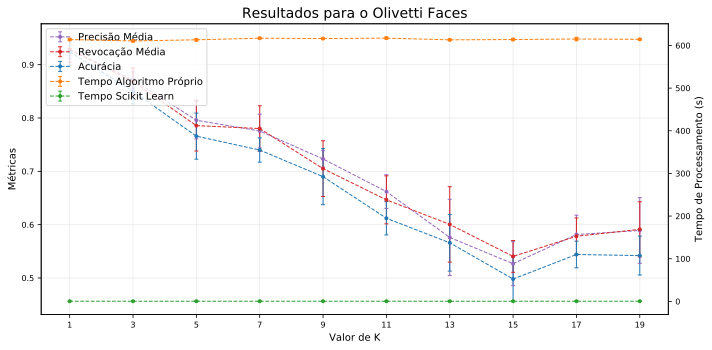

In [10]:
nomeDataset = "Olivetti Faces"

valoresK, mediaAcuracias, mediaPrecisoesMedias, mediaRevocacoesMedias, desvPadAcuracias, desvPadPrecisoesMedias, desvPadRevocacoesMedias, mediaTempoDimi, mediaTempoSK, desvPadTempoDimi, desvPadTempoSK = obterResultados(arrayMatrizConfusaoDimi, arrayTemposDimi, arrayTemposSKLearn)
plotar(nomeDataset, valoresK, mediaAcuracias, mediaPrecisoesMedias, mediaRevocacoesMedias, desvPadAcuracias, desvPadPrecisoesMedias, desvPadRevocacoesMedias, mediaTempoDimi, mediaTempoSK, desvPadTempoDimi, desvPadTempoSK)

# Printando a melhor e a pior matriz de confusão

In [28]:
for matriz in arrayMatrizConfusaoDimi[7]: # k = 1 foi o melhor
    objMetricas = Metricas(matriz)
    print(objMetricas.acuracia)

0.44
0.46
0.53
0.55
0.51


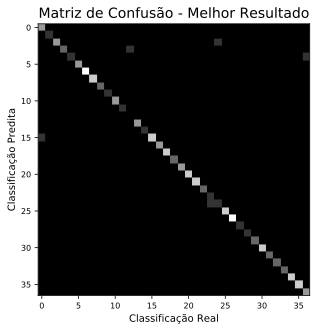

In [27]:
plt.imshow(arrayMatrizConfusaoDimi[0][1], cmap='gray')
plt.title("Matriz de Confusão - Melhor Resultado")
plt.xlabel("Classificação Real")
plt.ylabel("Classificação Predita")
caminhoSalvarPDF = "../resultados/imagens/matrizConfusaoOlivettiMelhorResultado.pdf"
plt.savefig(caminhoSalvarPDF, format='pdf', bbox_inches = 'tight')
plt.show()

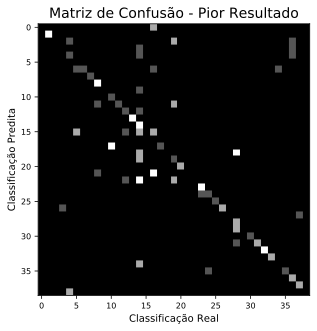

In [29]:
plt.imshow(arrayMatrizConfusaoDimi[7][0], cmap='gray')
plt.title("Matriz de Confusão - Pior Resultado")
plt.xlabel("Classificação Real")
plt.ylabel("Classificação Predita")
caminhoSalvarPDF = "../resultados/imagens/matrizConfusaoOlivettiPiorResultado.pdf"
plt.savefig(caminhoSalvarPDF, format='pdf', bbox_inches = 'tight')
plt.show()